In [95]:
# default import, might be useless

# deep learning library
import torch
import torchvision
from   torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# to import data
import torchvision.transforms as transforms 
import torchvision.datasets.mnist as mnist  

# we use torch.cuda.Event(enable_timing=True) to measure time
# if you don't have cuda, you can use instead :
# from timeit import default_timer as timer
# import time

import collections           # for ordered_dictionnary
import torch.nn.init as init # to initialize model

import copy # for copy.deepcopy( ... )

import numpy as np

# to make and display plots
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure 

# to format time to strings
import datetime                      

import math # for ceil ()

import IPython.display # to display .png

import time
import collections
import os
import sys
import torch
import torch.nn
from torch.autograd import Variable
import torch.nn as nn

In [1]:
import torch
import torchvision.datasets
import torchvision.transforms as transforms
from torch.utils.data import dataset
from torch import nn
# from torch.nn.modules import upsampling
# from torch.functional import F
from torch.optim import Adam

In [2]:
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5),
                         (.5, .5, .5))
])


def get_data_loader(dataset_location, batch_size):
    trainvalid = torchvision.datasets.SVHN(
        dataset_location, split='train',
        download=True,
        transform=image_transform
    )

    trainset_size = int(len(trainvalid) * 0.9)
    trainset, validset = dataset.random_split(
        trainvalid,
        [trainset_size, len(trainvalid) - trainset_size]
    )

    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    validloader = torch.utils.data.DataLoader(
        validset,
        batch_size=batch_size,
    )

    testloader = torch.utils.data.DataLoader(
        torchvision.datasets.SVHN(
            dataset_location, split='test',
            download=True,
            transform=image_transform
        ),
        batch_size=batch_size,
    )

    return trainloader, validloader, testloader

In [3]:
train, valid, test = get_data_loader("svhn", 32)

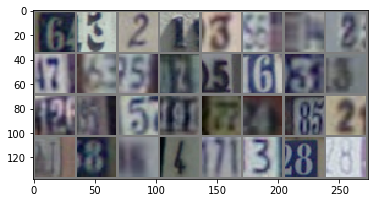

tensor(6)


In [47]:
# functions to show an image

def imshow(img):
    img = 0.5*(img + 1)
    npimg = img.numpy()
    # npimg = (255*npimg).astype(np.uint8) # to be a int in (0,...,255)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

print( labels[0] )

In [200]:
class MLP(nn.Module):
    """
    This is just an MLP with 1 hidden layer
    """
    def __init__(self, in_size, h_size, out_size, dropout=0.1):
        super(MLP, self).__init__()
        self.w_1 = nn.Linear(in_size, h_size  )
        self.w_2 = nn.Linear(h_size , out_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))
    
class UnFlatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), 16, 8, 8).contiguous()
    
class VAE(nn.Module):
    def __init__(self, drop_p = 0.3, kernel_s = 5, z_dim=100):
        super(VAE, self).__init__()
        
        self.drop_p   = drop_p
        self.kernel_s = kernel_s
        pad = (kernel_s - 1)//2
        
        self.encoder = nn.Sequential(
            # layer 1, input size for svhn : 3x32x32
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=kernel_s,padding=pad),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(p= drop_p),
            
            # layer 2
            nn.Conv2d(16, 32, kernel_size=kernel_s,padding=pad),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(p= drop_p),
            
            # layer 3
            nn.Conv2d(32, 64, kernel_size=kernel_s,padding=pad),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(p= drop_p),
            
            # layer 4
            nn.Conv2d(64, 128, kernel_size=kernel_s,padding=pad),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(p= drop_p),
            
            # layer 5
            nn.Conv2d(128, 256, kernel_size=kernel_s,padding=pad),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(p= drop_p),
        )
        encoder_conv_out_size = 2*2*256
        
        self.encode_to_avg = MLP(encoder_conv_out_size,2048, z_dim, dropout=drop_p)
        self.encode_to_std = nn.Sequential(
            MLP(encoder_conv_out_size,2048, z_dim, dropout=drop_p),
            nn.ELU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 16 * 8 * 8), nn.ReLU(),
            UnFlatten(),
            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(p= drop_p),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(p= drop_p),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(p= drop_p),
            nn.ConvTranspose2d(32,  3, kernel_size=3, stride=1, padding=1), 
            nn.Tanh()
        )
        
    def encode(self, x):
        h = self.encoder(x).view(x.size(0),-1)
        mu, std = self.encode_to_avg(h), self.encode_to_std(h)
        std = std + 1 + 1e-05 # added for stability, outout of ELU +1 can be 0
        return mu, std

    def reparameterize(self, m, v):
        eps = torch.randn_like(v)
        return m + eps*v

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, std = self.encode(x)
        z = self.reparameterize(mu, std)
        return self.decode(z), mu, std
    
    def init(self):
        def init_(layer):
            if type(layer) == nn.Linear or type(layer) == nn.Conv2d or type(layer) == nn.ConvTranspose2d:
                init.xavier_uniform_( layer.weight )
                layer.bias.data.fill_(0.0)
        self.apply(init_)

In [201]:
def number_of_params( net ) :
    nb_param  = 0
    depth     = 0 # count the number of different bias
    param_lst = " "
    for i, (key, value) in enumerate( net.state_dict().items() ) :
        if key.endswith("bias") :
            depth = depth + 1            
        nb_param_tmp = 1        
        for j , x in enumerate(value.size()) :               
            nb_param_tmp = nb_param_tmp * x                
        nb_param = nb_param + nb_param_tmp     
    return nb_param, depth

In [202]:
model = VAE()
num_p, depth = number_of_params(model)
print( num_p )

5827699


In [203]:
model_VAE = VAE()
model_VAE.init()
_ = model_VAE.to(device)

In [204]:
dataiter = iter(trainset)
images, labels = dataiter.next()
images = images.to(device)
print( model_VAE(images)[0].shape )
print( model_VAE(images)[0].min() )
print( model_VAE(images)[0].max() )

torch.Size([128, 3, 32, 32])
tensor(-0.9997, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)


In [194]:
def kl_loss(z_avg, z_std):
    kl_loss = 0.5 * torch.sum(-1 - 2*z_std.log() + z_avg**2 + z_std**2, dim=-1)
    return kl_loss

sqrt_2p = math.log(2 * math.pi)
def log_px_z(x, x_decoded_mean):
    loss = 0.5 * ( sqrt_2p + (x - x_decoded_mean)**2 )
    loss = torch.sum(loss.view(x.size(0),-1), dim=-1)
    return -loss

def vae_loss(x, x_decoded_mean, z_avg, z_std):
    logprob = log_px_z(x, x_decoded_mean)
    kldiv   = kl_loss(z_avg, z_std)
    kldiv_  = torch.max(kldiv, 5 * torch.ones_like(kldiv)) # prevent kl_div to go to zero
    return - ( logprob - kldiv_), kldiv

In [158]:
# sets are called train, valid, test
batch_size = 128
trainset, validset, testset = get_data_loader("svhn", batch_size)

Using downloaded and verified file: svhn\train_32x32.mat
Using downloaded and verified file: svhn\test_32x32.mat


In [195]:
# Use the GPU if you have one
if torch.cuda.is_available():
    print("Using the GPU")
    device = torch.device("cuda") 
else:
    print("WARNING: You are about to run on cpu")
    device = torch.device("cpu")


def train(model,optimizer,loader,epoch):
    model.train()
    train_loss = 0
    train_step = 0
    for batch_idx, (data,_) in enumerate(loader):
        if batch_idx == 0:
            bs = data.size(0) # batch size 
            
        data = data.to(device)
        optimizer.zero_grad()
        x_hat, z_avg, z_std = model(data)
        loss, kl_div = vae_loss(data, x_hat, z_avg, z_std)
        loss = loss.mean()
        kl_div = kl_div.mean()
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            n_batch_seen = batch_idx + 1
            print('Train Epoch: {} ({:.0f}%)\tELBO: {:.6f} \tKL div: {:.6f}'.format(
                epoch, 100* n_batch_seen // len(loader), train_loss / n_batch_seen, kl_div) )

    # Normalize per instance
    avg_loss = train_loss / len(loader)
    print('====> Epoch: {} - Train set - Per instance ELBO: {:.4f}'.format(
        epoch, avg_loss ))
    return avg_loss

def valid(model,optimizer,loader,epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (data,_) in enumerate(loader):
            if batch_idx == 0:
                bs = data.size(0) # batch size 
                
            data = data.to(device)
            x_hat, z_avg, z_std = model(data)
            loss, _ = vae_loss(data, x_hat, z_avg, z_std)
            loss    = loss.mean()
            test_loss += loss.item()
                
    # Normalize per instance.
    avg_loss = test_loss / len(loader)                
    print('====> Epoch: {} - Test set - Per Instance ELBO: {:.4f}'.format(
        epoch, avg_loss))
    return avg_loss

Using the GPU


In [196]:
print(len(trainset.dataset))
print(len(validset.dataset))
print(len(testset.dataset))

65931
7326
26032


In [205]:
save_dir = "save"

train_losses = []
valid_losses = []
times        = []
best_val_so_far = np.inf

In [206]:
model_VAE = VAE()
model_VAE.init()

In [207]:
# optimizer = optim.Adam(model_VAE.parameters(), lr=5*1e-3, eps=1e-4)
optimizer = optim.Adam(model_VAE.parameters())
cuda = torch.cuda.is_available()
if cuda:
    model_VAE = model_VAE.cuda()

In [ ]:
n_epochs = 10
for epoch in range(1, n_epochs + 1):
    t0 = time.time()
    
    train_loss = train(model_VAE,optimizer,trainset,epoch)
    valid_loss = valid(model_VAE,optimizer,validset,epoch)
    if valid_loss < best_val_so_far:
        best_val_so_far = valid_loss
        print("Saving model parameters to best_params.pt")
        torch.save(model_VAE.state_dict(), os.path.join(save_dir, 'best_params.pt'))
    
     # LOC RESULTS
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    times.append(time.time() - t0)
    log_str = 'epoch: ' + str(epoch) + '\n' \
            + 'train loss: ' + str(train_loss) + '\n' \
            + 'valid loss: ' + str(valid_loss)  + '\n' \
            + 'best val: '   + str(best_val_so_far) + '\n' \
            + 'time (s) spent in epoch: ' + str(times[-1])
    print(log_str)
    with open (os.path.join(save_dir, 'log.txt'), 'a') as f_:
        f_.write(log_str+ '\n')

# SAVE LEARNING CURVES
lc_path = os.path.join(save_dir, 'learning_curves.npy')
print('\nDONE\n\nSaving learning curves to '+lc_path)
np.save(lc_path, {'train_losses':train_losses,
                  'valid_losses':valid_losses,
                  'times':times})

Train Epoch: 1 (0%)	ELBO: 3390.345215 	KL div: 25.506729
Train Epoch: 1 (19%)	ELBO: 3021.622385 	KL div: 10.718122
Train Epoch: 1 (38%)	ELBO: 2989.703608 	KL div: 8.976341


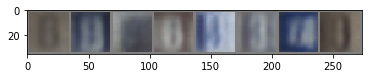

In [162]:
model_VAE.eval()
with torch.no_grad() :
    z_dim = 100
    bs    = 8
    mu    = torch.zeros(bs,z_dim)
    std   = torch.ones(bs,z_dim)
    z     = model_VAE.reparameterize(mu,std).to(device)
    gen   = model_VAE.decode(z)
    gen_  = gen.cpu()
    # print(gen_.shape)
    imshow(torchvision.utils.make_grid(gen_))

# Qualitative evaluation

torch.Size([11, 100])


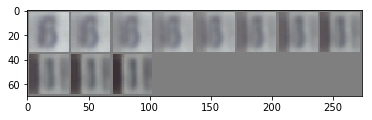

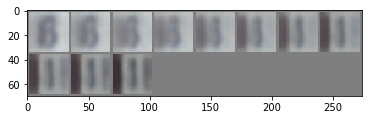

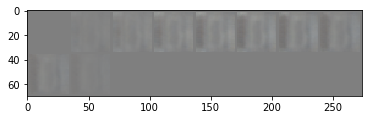

In [174]:
def lazy_interpolation(model,z):
    alpha = torch.linspace(0, 1, steps=11)
    alpha = torch.transpose(alpha.repeat(1,3,32,32,1),0,-1).squeeze(-1)
    alpha = alpha.to(device)
    g = model.decoder(z)
    g = g[0].unsqueeze(0).repeat(11,1,1,1)*(1-alpha) + g[1].unsqueeze(0).repeat(11,1,1,1)*alpha
    return g
    
def latent_interpolation(model,z):
    alpha = torch.linspace(0, 1, steps=11)
    alpha = torch.transpose(alpha.repeat(100,1),0,-1)
    alpha = alpha.to(device)
    z = z[0].unsqueeze(0).repeat(11,1)*(1-alpha) + z[1].unsqueeze(0).repeat(11,1)*alpha
    print( z.shape )
    g = model.decoder(z)
    return g

_ = model_VAE.to(device)
model_VAE.eval()
with torch.no_grad() :
    z_dim = 100
    bs    = 2
    mu    = torch.zeros(bs,z_dim)
    std   = 1*torch.ones(bs,z_dim)
    z     = model_VAE.reparameterize(mu,std).to(device)
    lz_interpol = lazy_interpolation(model_VAE,z).cpu()
    lt_interpol = latent_interpolation(model_VAE,z).cpu()

    imshow(torchvision.utils.make_grid(lz_interpol))
    imshow(torchvision.utils.make_grid(lt_interpol))
    # diff between the 2 interpol
    imshow(torchvision.utils.make_grid(lt_interpol-lz_interpol))